In [1]:
import time
nb_start_time = time.time()

In [2]:
# import libraries
import json
import sys
import os
from tqdm import tqdm
from tqdm import trange
import pandas as pd
import numpy as np
import torch
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')

np.random.seed(42)

In [3]:
# import scripts

import config as config
from scripts.matching import match_behaviors
import src.data_prep.create_segments_and_metadata as create_segments_and_metadata
import src.data_prep.data_prep_utils as data_prep_utils
import src.data_prep.create_matched_data_objects as create_matched_data_objects
import src.utils.data as utils_data
import src.utils.io as utils_io
import src.utils.plot as utils_plot
from src.methods.prediction_model import create_dynamic_conv_model
from src.utils.train import (training_loop,
                             multi_label_eval_loop,
                             train_run)
from src.utils.plot import(multi_label_predictions,
                            plot_signal_and_online_predictions)
from src.methods.online_predictions import (online_score_evaluation,
                                            online_smoothening)
from src.utils.simulations import (plot_simulated_day,
                                    simulate_fourier_signal,
                                    generate_acc_data,
                                    simulate_axis_signal,
                                    simulate_markov_acc_day)
from dataclasses import dataclass

In [4]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams['legend.fontsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

## Creating simulated data

We create simulated acceleration and annotations data. We consider five behavioral categories of interest: 
 - Eating
 - Resting
 - Walking
 - Running
 - Grooming

Let the tri-axial acceleration at time $t$ for behavior $a$ be denoted by $(X^a(t), Y^a(t), Z^a(t))$. The acceleration signal for each behavior and each direction is simulated using the fourier breakdown of the signal into 5 sets of frequencies, amplitudes, and phase information. Let the (frequency, amplitude, phase) set for $a$ behavior along $X$ axis be denoted by $$(f_{X, i}^a, A_{X,i}^a, \phi_{X, i}^a)_{i=[5]}$$
The sets are defined similarly for other axes and behaviors. Additionally, Gaussian noise with variuance $\sigma_X^2$ (resp. $\sigma_Y^2$ and $\sigma_Z^2$) for X (resp. Y and Z) axisis added to the signal. Therefore, the data is simulated as
$$X^a(t) = \sum_{i=1}^5 A_{X, i}^a \sin(2\pi f_{X,i}^a t + \phi_{X, i}^a) + \mathcal{N}(0, \sigma_X^2).$$


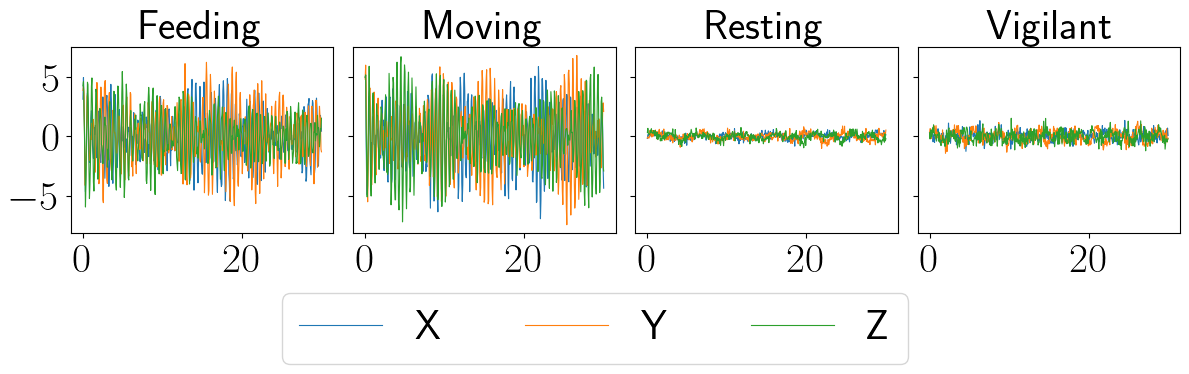

In [5]:
t = np.linspace(0, 30, 30*config.SAMPLING_RATE)
data_constants = config.SIMULATION_CONSTANTS

fig, axs = plt.subplots(1, len(config.SIM_BEHAVIORS), figsize=(3*len(config.SIM_BEHAVIORS),3), sharey=True)
for i, observed_behavior in enumerate(config.SIM_BEHAVIORS):
    f_X, A_X, phi_X, sigma_X = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == "X"), ['f', 'A', 'phi', 'sigma']].values[0]
    f_Y, A_Y, phi_Y, sigma_Y = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == "Y"), ['f', 'A', 'phi', 'sigma']].values[0]
    f_Z, A_Z, phi_Z, sigma_Z = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == "Z"), ['f', 'A', 'phi', 'sigma']].values[0]

    signal_x = simulate_axis_signal(f_X, A_X, phi_X, sigma_X, len(t))
    signal_y = simulate_axis_signal(f_Y, A_Y, phi_Y, sigma_Y, len(t))
    signal_z = simulate_axis_signal(f_Z, A_Z, phi_Z, sigma_Z, len(t))

    if i == 0:
        axs[i].plot(t, signal_x, label="X", linewidth=0.8)
        axs[i].plot(t, signal_y, label="Y", linewidth=0.8)
        axs[i].plot(t, signal_z, label="Z", linewidth=0.8)
    else:
        axs[i].plot(t, signal_x, linewidth=0.8)
        axs[i].plot(t, signal_y, linewidth=0.8)
        axs[i].plot(t, signal_z, linewidth=0.8)

    axs[i].set_title(observed_behavior)

fig.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5,-0.3))
plt.tight_layout()
plt.show()



## Result 1: Class Imbalance

We simulate data with extreme class imabalance. We assume the following class distribution for the behaviors of interest.


| Behavior | Probability of occurence |
|----------|--------------------------|
| Feeding  |  0.05   |
| Moving   | 0.2 |
| Resting  | 0.4 |
| Vigilant | 0.35 |

In [69]:
# Define individuals and years of dataset available for them

n_individuals = 3
individuals = {f'individual{i+1}': [2022] for i in range(n_individuals)}

behavior_prob = [0.05, 0.2, 0.4, 0.35]
print("CLASS DISTRIBUTION")
for b, p in zip(config.SIM_BEHAVIORS, behavior_prob):
    print(f"{b:<10}: {p}")

# Create directories and generate acceleration data
os.makedirs(config.TEST_ROOT_DIR, exist_ok=True)
results_dir = os.path.join(config.TEST_ROOT_DIR, "class_imbalance")
os.makedirs(results_dir, exist_ok=True)

# define paths for various objects for this result subsection
annotations_path = results_dir+"/test_all_annotations.csv"
metadata_path = results_dir+"/test_metadata.csv"
data_path = os.path.join(results_dir, "data")
os.makedirs(data_path, exist_ok=True)
training_results_dir = os.path.join(results_dir, "training_results")
os.makedirs(training_results_dir, exist_ok=True)

matched_summary_path = data_path+"/matched_acc_summary.csv"
matched_data_path = data_path+"/matched_acc_data.csv"
matched_metadata_path = data_path+"/matched_acc_metadata.csv"


CLASS DISTRIBUTION
Feeding   : 0.05
Moving    : 0.2
Resting   : 0.4
Vigilant  : 0.35


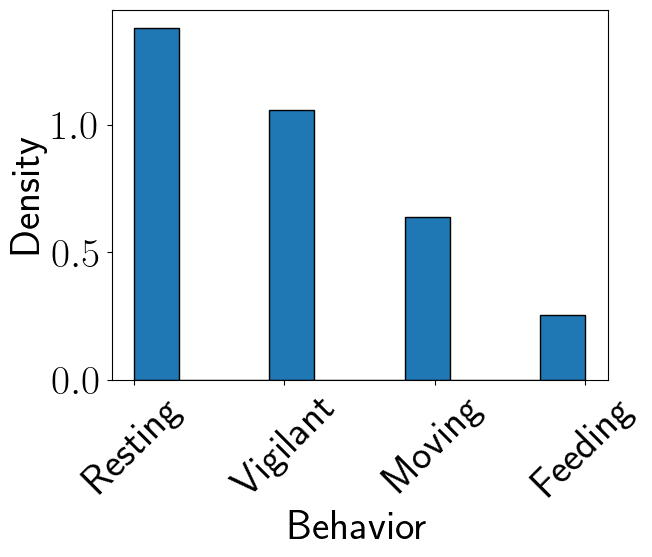

In [7]:
# load annotations
annotations_df = pd.read_csv(annotations_path)

plt.hist(annotations_df['Behavior'], edgecolor='black', density=True)
plt.xticks(rotation=45) 
plt.xlabel("Behavior")  # Label x-axis
plt.ylabel("Density")  # Label y-axis
plt.show()

In [8]:
# load metadata and annotations
metadata = pd.read_csv(metadata_path)

# load the saved matched data objects 
acc_summary = pd.read_csv(matched_summary_path)
acc_data = pd.read_csv(matched_data_path)
acc_data_metadata = pd.read_csv(matched_metadata_path)

In [9]:
@dataclass
class Arguments:
    experiment_name: str
    batch_size: int
    window_duration_percentile: float
    window_duration: float
    train_test_split: float
    train_val_split: float
    padding: str
    theta: float
    filter_type: str
    cutoff_frequency: float
    cutoff_order: int
    normalization: int
    match: int
    min_duration: float
    n_CNNlayers: int
    n_channels: int
    kernel_size: int
    learning_rate: float
    weight_decay: float
    num_epochs: int
    alpha: float
    verbose: int

args = Arguments(
    experiment_name='no_split', batch_size=64, window_duration_percentile=None,
    window_duration=30.0, train_test_split=0.2, train_val_split=0.2, padding='repeat', theta=0.0, 
    filter_type='high', cutoff_frequency=0, cutoff_order=5, normalization=0,
    match=0, min_duration=1.0, n_CNNlayers=3, n_channels=16, kernel_size=5,
    learning_rate=0.0001, weight_decay=0.0001, num_epochs=200, alpha=0.05, verbose=0
)


In [10]:
start = time.time()
X_train, y_train, z_train, X_val, y_val, z_val, X_test, y_test, z_test, _ = utils_data.setup_data_objects(metadata=metadata, 
                                                                                                    all_annotations=annotations_df, 
                                                                                                    collapse_behavior_mapping={}, 
                                                                                                    behaviors=config.SIM_BEHAVIORS, 
                                                                                                    args=args, 
                                                                                                    reuse_behaviors=config.SIM_BEHAVIORS,
                                                                                                    acc_data_path=matched_data_path,
                                                                                                    acc_metadata_path=matched_metadata_path
                                                                                                    )
n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(np.concatenate((y_train, y_val, y_test))))

print("Train Class distribution")
print("==========================")
print(pd.DataFrame(np.unique(y_train, return_counts=True)[1]))
print("")

time_diff = time.time() - start

print("")
print(f'Creating data objects takes {time_diff:.2f} seconds.')
print("")
print("Shape of dataframes")
print("==========================")
print(f"{'Set':<8} {'X':<15} {'Y':<10} {'Z':<15}")
print(f"{'Train:':<8} {str(X_train.shape):<15} {str(y_train.shape):<10} {str(z_train.shape):<15}")
print(f"{'Val:':<8} {str(X_val.shape):<15} {str(y_val.shape):<10} {str(z_val.shape):<15}")
print(f"{'Test:':<8} {str(X_test.shape):<15} {str(y_test.shape):<10} {str(z_test.shape):<15}")

Using pre-matched acceleration-behavior pairs...
Total number of matched annotations: 983
Before overlap, 
no. of train observations: 983, no. of test observations: 983
Overlapping indices of shape = (983,)
After removing overlaps, 
no. of train observations: 786, no. of test observations: 197

Matching annotations to acceleration snippets takes 25.412160 seconds


/home/medhaaga/AWD-Biologging/notebooks/../src/utils/data.py:318: UserWarning: train and test filters overlap
  warnings.warn("train and test filters overlap", UserWarning)


Creating fixed-duration windows takes 4.787627 seconds.

Time series duration window = 30.0
Train Class distribution
      0
0   118
1   466
2  1420
3  1071


Creating data objects takes 30.40 seconds.

Shape of dataframes
Set      X               Y          Z              
Train:   (3075, 3, 480)  (3075,)    (3075, 7)      
Val:     (769, 3, 480)   (769,)     (769, 7)       
Test:    (999, 3, 480)   (999,)     (999, 7)       


In [11]:
def plot_raw_time_series(X, y, save_path=None):
    """
    Plot raw time series data for each unique class in y.

    Parameters:
    - X (np.ndarray): 3D array of time series data with shape (n_samples, n_channels, n_time_steps).
    - y (np.ndarray): Array of class labels corresponding to each sample in X.
    """

    unique_classes = np.unique(y)
    n_classes = len(unique_classes)

    fig, axs = plt.subplots(1, n_classes, figsize=(4 * n_classes, 4), sharex=True, sharey=True)
    if n_classes == 1:
        axs = [axs]

    custom_palette = sns.color_palette("husl", 3)
    handles = []
    labels = []

    for j, cls in enumerate(unique_classes):
        i = np.random.choice(np.where(y == cls)[0])
        time = np.linspace(0, X.shape[2] / 16, X.shape[2])

        # Plot each channel with corresponding colors
        for k, label in enumerate(['X', 'Y', 'Z']):
            line, = axs[j].plot(time, X[i, k, :], label=label, color=custom_palette[k], linewidth=0.8)
            if j == 0:  # Collect handles and labels only from the first subplot
                handles.append(line)
                labels.append(label)

        # Set title for the subplot
        axs[j].set_title(f'{cls}')
        axs[j].set_xlabel('Time (s)')

    axs[0].set_ylabel('Amplitude (g)')
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15))

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

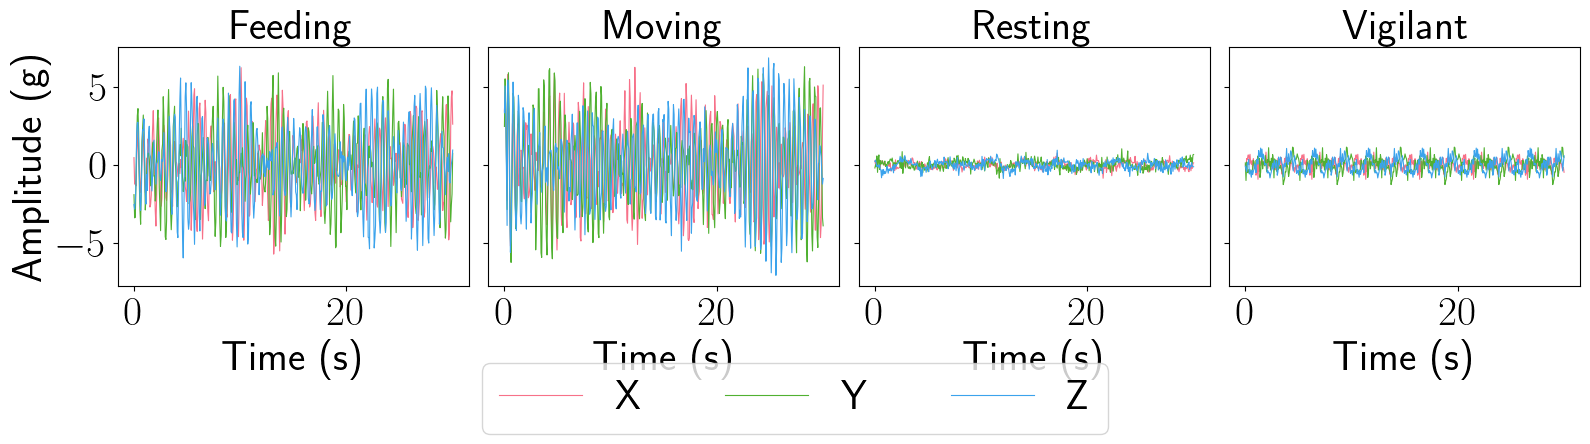

In [12]:
## fit a label encoder

label_encoder = LabelEncoder()
label_encoder.fit(config.SIM_BEHAVIORS)
plot_raw_time_series(X_test, label_encoder.inverse_transform(y_test))

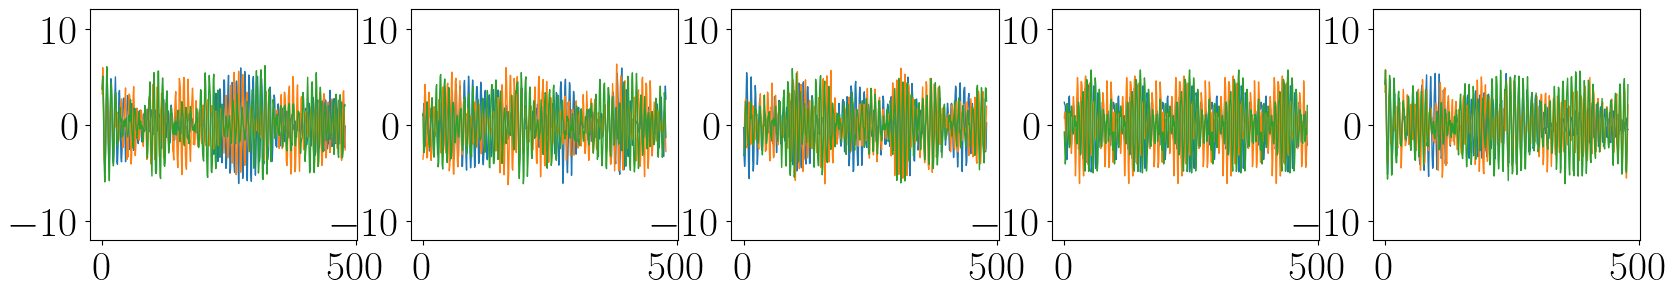

In [13]:
_, counts = np.unique(y_test, return_counts=True)
feeding_idx = np.where(y_test == 0)[0]
fig, axs = plt.subplots(1, min(5, counts[0]), figsize=(4*min(5, counts[0]),3))
for i in range(min(5, counts[0])):
    idx = feeding_idx[0+i]
    axs[i].plot(np.arange(X_test.shape[-1]), X_test[idx,0,:], linewidth=1.0)
    axs[i].plot(np.arange(X_test.shape[-1]), X_test[idx,1,:], linewidth=1.0)
    axs[i].plot(np.arange(X_test.shape[-1]), X_test[idx,2,:], linewidth=1.0)
    axs[i].set_ylim(-12,12)
plt.show()

In [14]:
dir = os.path.join(training_results_dir, f"theta0.0")
json_training_stats_file = os.path.join(dir, 'training_stats.json')

with open(json_training_stats_file, 'r') as f:
    training_stats = json.load(f)

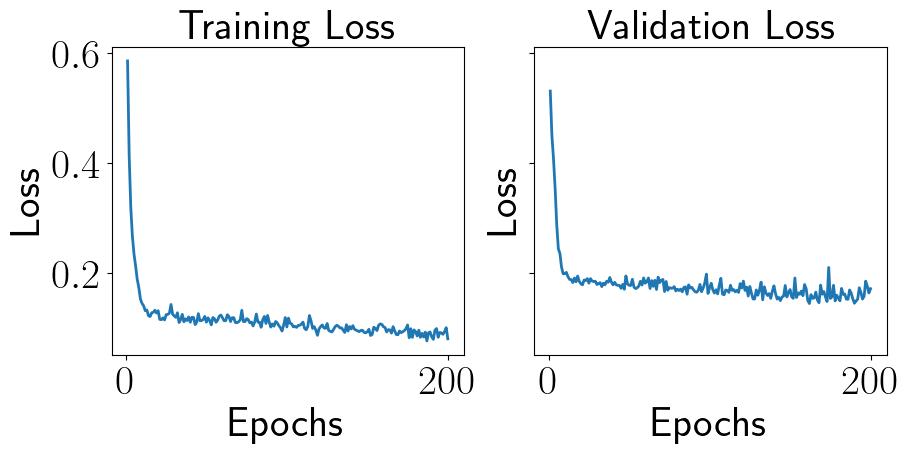

In [15]:
#plot training stats
training_stats = pd.DataFrame(training_stats)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].plot(training_stats['epoch'], training_stats['Training Loss'])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")

axs[1].plot(training_stats['epoch'], training_stats['Validation Loss'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Validation Loss")
plt.show()

[0.90582121 0.85103    0.86636635 0.86873104 0.88666436 0.88899428]


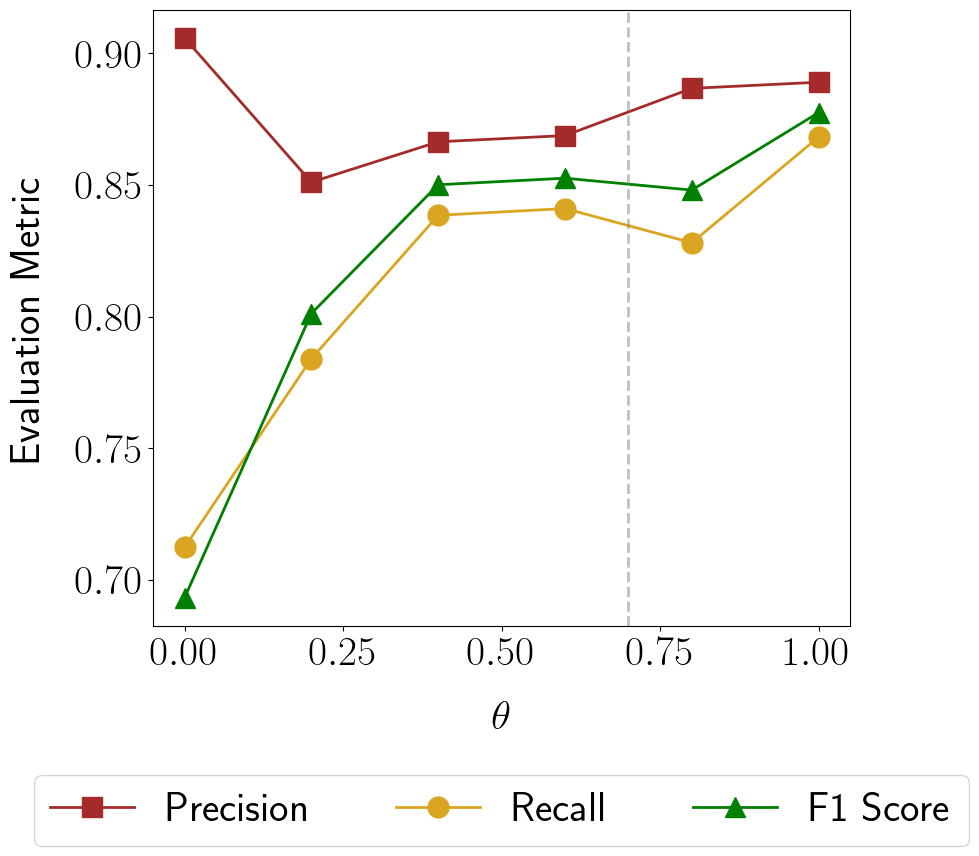

In [16]:
# you need to run 'scrpts/no_split.sh' for produce the hyperparameter finetuning plots.

thetas = np.round(0.2*np.arange(0, 6), 1)
colors = ['brown', 'goldenrod', 'green']

precisions = np.zeros(len(thetas))
recalls = np.zeros(len(thetas))
f1scores = np.zeros(len(thetas))

for i, theta in enumerate(thetas):
    dir = os.path.join(training_results_dir, f"theta{theta}")
    # dir = os.path.dirname(os.path.dirname(dir))
    precisions[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)


print(precisions)

plt.figure(figsize=(9,8))
plt.plot(thetas, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(thetas, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(thetas, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.axvline(0.7, color='grey', alpha=0.5, linestyle='--')
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)
plt.legend(loc='center', bbox_to_anchor=(.5, -0.3), ncol=3)
# plt.tight_layout()
plt.savefig('../figures/no_split-theta_tuning.pdf', format="pdf", bbox_inches="tight")
plt.show()

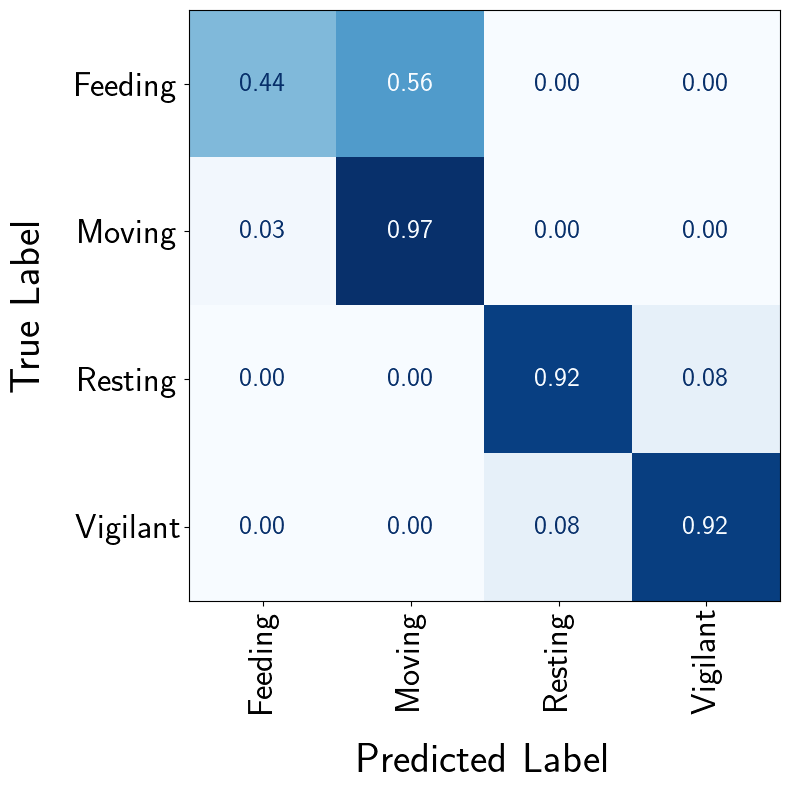

In [17]:
dir = os.path.join(training_results_dir, f"theta0.0")
y= np.load(os.path.join(dir, 'test_true_classes.npy'))
y_hat= np.load(os.path.join(dir, 'test_predictions.npy'))

multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=None)

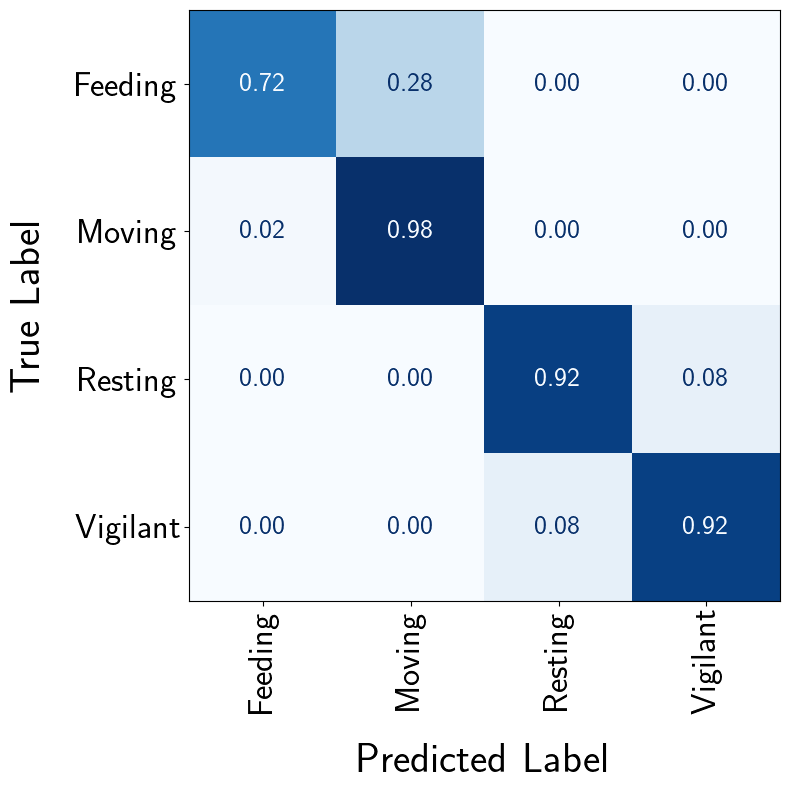

In [18]:
dir = os.path.join(training_results_dir, f"theta1.0")
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=None)

## Result 1: Uncertainty Quantification

We simulate data with extreme class imabalance. We assume the following class distribution for the behaviors of interest.


In [27]:
from src.methods.conformal_prediction import *
from src.utils.conformal import *

model_dir = os.path.join(training_results_dir, f"theta1.0")
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

if device == torch.device("cpu"):
    model = torch.load(os.path.join(model_dir, 'model.pt'), map_location=torch.device('cpu'))
else:
    model = torch.load(os.path.join(model_dir, 'model.pt'))

cdataloader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=args.batch_size, shuffle=False)
cmodel = ConformalModel(model, cdataloader, alpha=0.05, randomized=True, lamda_criterion='size').to(device)
torch.save(cmodel, os.path.join(model_dir, 'cmodel.pt'))

/tmp/ipykernel_647717/3761805829.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(model_dir, 'model.pt'), map_location=torch.device('cpu')

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 13/13 [00:00<00:00, 323.25it/s]


Optimal T=0.7810497283935547


In [28]:
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

N: 999 | Avg Time: 0.004 | Avg Cvg@1: 0.924 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.966 | Avg Size@RAPS: 1.528



As an example, there are a total of 6 **feeding** labels that are incorrectly predicted as **moving** by the most-likely prediction. 

In [30]:
scores, psets = cmodel(torch.Tensor(X_test).float().to(device))
scores = scores.detach().cpu().numpy()
most_likely = np.argmax(scores, axis=1)
idx = np.where((y_test == 0) & (most_likely != y_test))[0]
for id in idx:
    print(f"{str(label_encoder.inverse_transform(psets[id])):<20} with scores {scores[id][list(psets[id])]}")

['Moving' 'Feeding'] with scores [0.9987997  0.00137929]
['Moving' 'Feeding'] with scores [0.85495174 0.251357  ]
['Moving' 'Feeding'] with scores [0.9896672  0.01172565]
['Moving']           with scores [0.73146147]
['Moving' 'Feeding'] with scores [0.49644396 0.48359793]
['Moving']           with scores [0.97174996]


In [42]:
print(f"{np.round(((1-no_split_test_top1) - (1-no_split_test_coverage)) / (1-no_split_test_top1), 5)}% of incorrectly predicted observations are in the RAPS.")

0.55263% of incorrectly predicted observations are in the RAPS.


In [112]:
for observed_behavior in config.SIM_BEHAVIORS:
    print(observed_behavior)
    label = label_encoder.transform([observed_behavior])
    mask = (y_test == label)
    ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[mask], dtype=torch.float32), torch.tensor(y_test[mask])), batch_size=args.batch_size, shuffle=False)
    no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

    

Feeding
N: 39 | Avg Time: 0.007 | Avg Cvg@1: 0.846 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.872 | Avg Size@RAPS: 1.410

Moving
N: 153 | Avg Time: 0.005 | Avg Cvg@1: 0.967 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.987 | Avg Size@RAPS: 1.248

Resting
N: 468 | Avg Time: 0.003 | Avg Cvg@1: 0.921 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.955 | Avg Size@RAPS: 1.382

Vigilant
N: 339 | Avg Time: 0.003 | Avg Cvg@1: 0.917 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.950 | Avg Size@RAPS: 1.301



In [113]:
test_scores = np.load(os.path.join(model_dir, 'test_scores.npy'))
mask = (np.max(test_scores, axis=1) < 0.9)

# test observations with high score
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[mask], dtype=torch.float32), torch.tensor(y_test[mask])), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

# test observations with low score
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[~mask], dtype=torch.float32), torch.tensor(y_test[~mask])), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

N: 195 | Avg Time: 0.003 | Avg Cvg@1: 0.862 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.938 | Avg Size@RAPS: 1.467

N: 804 | Avg Time: 0.003 | Avg Cvg@1: 0.939 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.964 | Avg Size@RAPS: 1.299



#### Comparing the time spent in each behavior

In [114]:
config.SIM_BEHAVIORS

['Feeding', 'Moving', 'Resting', 'Vigilant']

/home/medhaaga/AWD-Biologging/notebooks/../src/utils/simulations.py:365: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


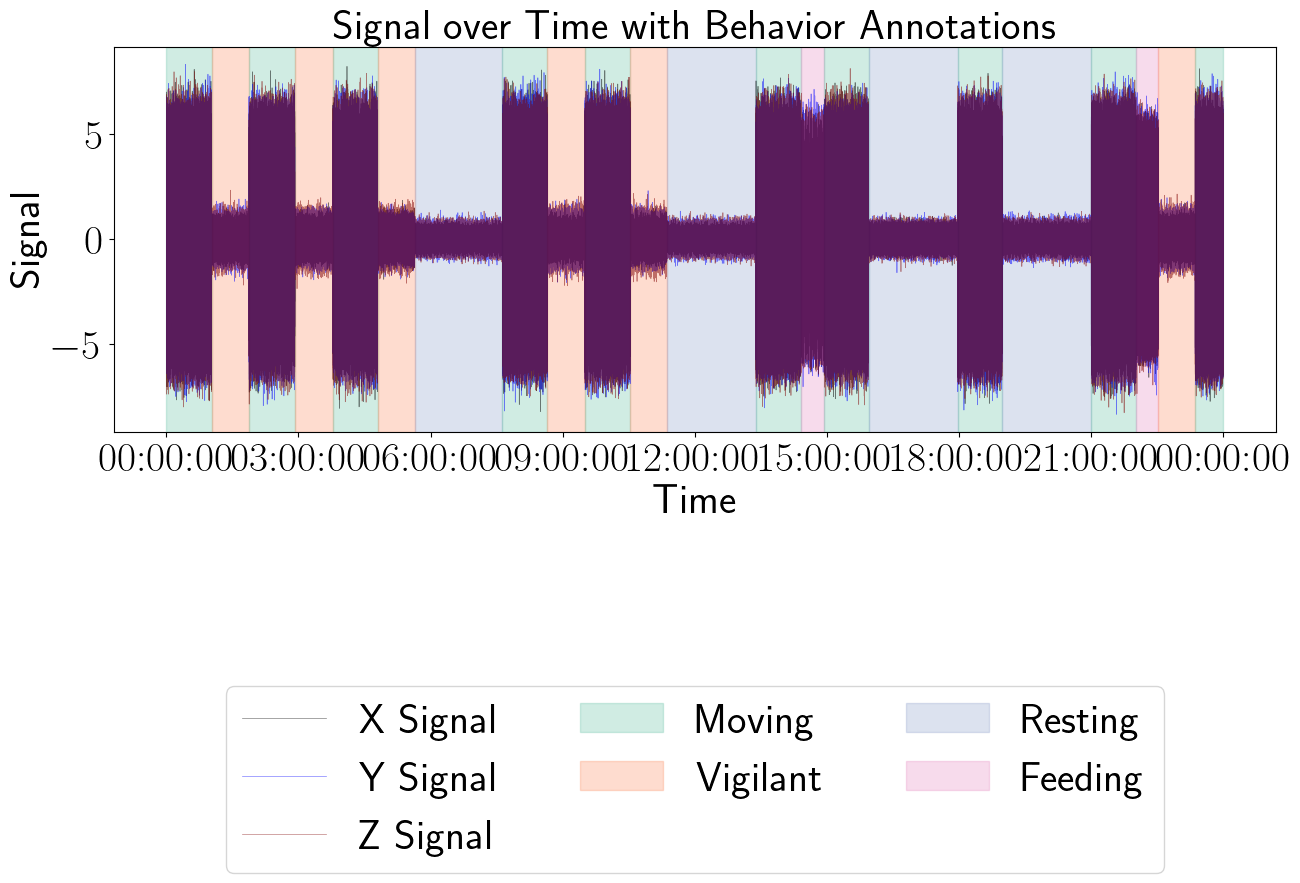

In [115]:
transition_matrix = np.array([
    [0.0, 0.7, 0.0, 0.3],  # from Feeding
    [0.4, 0.0, 0.2, 0.4],  # from Moving
    [0.0, 0.6, 0.0, 0.4],  # from Resting
    [0.0, 0.5, 0.5, 0.0],  # from Vigilant
])
avg_durations = {
    "Feeding": {"min": 30, "sec": 60},
    "Moving": {"min": 60, "sec": 60},
    "Resting": {"min": 120, "sec": 60},
    "Vigilant": {"min": 50, "sec": 60}
}
# Convert to DataFrame
avg_durations = pd.DataFrame.from_dict(avg_durations, orient="index")
avg_durations.index.name = "Behavior"
avg_durations.columns.name = "DurationUnit"

acc_df, annotations_df = simulate_markov_acc_day(config.SIMULATION_CONSTANTS, transition_matrix, avg_durations)
plot_simulated_day(acc_df)

The time spent in each behavior for a simulated 24 hours accelerationbehavior data is displayed below.

In [116]:
window_duration = 30.0
window_length = int(window_duration * config.SAMPLING_RATE)

acc_df['Timestamp'] = pd.to_datetime(acc_df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
acc_df.sort_values(by='Timestamp', inplace=True)
signal = torch.tensor(np.array([acc_df['Acc X [g]'].values, acc_df['Acc Y [g]'].values, acc_df['Acc Z [g]'].values])).float().unsqueeze(0)
smoothening_config = {'smoothening_window_length': 1,
                          'smoothening_hop_length': 1,
                          'score_hop_length': None
                          }
scores = online_score_evaluation(model_dir=model_dir, 
                                X=signal, window_duration=window_duration, 
                                window_length=None, hop_length=smoothening_config['score_hop_length'], 
                                sampling_frequency=config.SAMPLING_RATE)

behavior_counts = acc_df['Behavior'].value_counts()
behavior_durations = (behavior_counts / config.SAMPLING_RATE)/3600

print("Time Spent in Each Behavior for the simulated data")
print(behavior_durations)

/home/medhaaga/AWD-Biologging/notebooks/../src/methods/online_predictions.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load(os.path.join(model_dir, 'c

Time Spent in Each Behavior for the simulated data
Behavior
Moving      9.819010
Resting     8.067448
Vigilant    5.081354
Feeding     1.031736
Name: count, dtype: float64


['Feeding' 'Moving']
['Feeding' 'Moving']


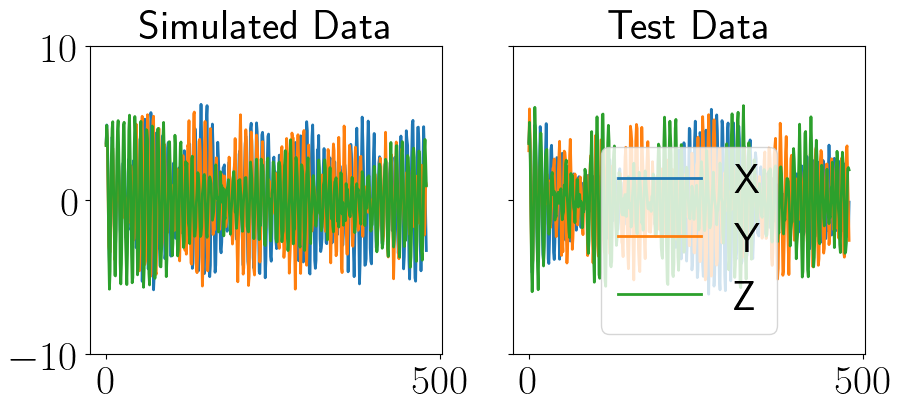

In [117]:
f_X, A_X, phi_X, sigma_X = data_constants.loc[(data_constants["Behavior"] == 'Feeding') & (data_constants["Axis"] == "X"), ['f', 'A', 'phi', 'sigma']].values[0]
f_Y, A_Y, phi_Y, sigma_Y = data_constants.loc[(data_constants["Behavior"] == 'Feeding') & (data_constants["Axis"] == "Y"), ['f', 'A', 'phi', 'sigma']].values[0]
f_Z, A_Z, phi_Z, sigma_Z = data_constants.loc[(data_constants["Behavior"] == 'Feeding') & (data_constants["Axis"] == "Z"), ['f', 'A', 'phi', 'sigma']].values[0]

signal_x = simulate_axis_signal(f_X, A_X, phi_X, sigma_X, window_length)
signal_y = simulate_axis_signal(f_Y, A_Y, phi_Y, sigma_Y, window_length)
signal_z = simulate_axis_signal(f_Z, A_Z, phi_Z, sigma_Z, window_length)


simulated_feeding_signal = np.stack([signal_x, signal_y, signal_z], axis=0)
simulated_feeding_signal = simulated_feeding_signal[np.newaxis, :, :]

fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)
axs[0].plot(np.arange(simulated_feeding_signal.shape[-1]), simulated_feeding_signal[0,0,:], label="X")
axs[0].plot(np.arange(simulated_feeding_signal.shape[-1]), simulated_feeding_signal[0,1,:], label="Y")
axs[0].plot(np.arange(simulated_feeding_signal.shape[-1]), simulated_feeding_signal[0,2,:], label="Z")
axs[0].set_ylim(-10,10)
axs[0].set_title("Simulated Data")
s, pset = cmodel(torch.tensor(simulated_feeding_signal).float().to(device))
print(label_encoder.inverse_transform(pset[0]))

feeding_idx = np.where(y_test == 0)[0]
feeding_X = X_test[feeding_idx[0], :, :]
feeding_X = torch.tensor(feeding_X).unsqueeze(0).float()
axs[1].plot(np.arange(feeding_X.shape[-1]), feeding_X[0,0,:], label="X")
axs[1].plot(np.arange(feeding_X.shape[-1]), feeding_X[0,1,:], label="Y")
axs[1].plot(np.arange(feeding_X.shape[-1]), feeding_X[0,2,:], label="Z")
axs[1].set_title("Test Data")
s, pset = cmodel(feeding_X.to(device))
print(label_encoder.inverse_transform(pset[0]))
plt.legend()
plt.show()

In [118]:
top1_behaviors = np.argmax(scores, axis=1)  # shape (1, B, W)
unique, counts = np.unique(top1_behaviors, return_counts=True)

total_top1_durations = dict(zip(label_encoder.inverse_transform(unique), np.round(counts *32/3600, 4)))
print("TOP-1 PREDICTION DURATIONS")
print(total_top1_durations)

TOP-1 PREDICTION DURATIONS
{'Feeding': 0.8178, 'Moving': 10.72, 'Resting': 8.64, 'Vigilant': 5.4133}


In [119]:
@dataclass
class BehaviorMetrics:
    duration: float
    count: int
    raps_cvg: int
    top1_cvg: int
        
total_raps_metrics = {behavior: BehaviorMetrics(duration=0.0, count=0, raps_cvg=0, top1_cvg=0) for behavior in config.SIM_BEHAVIORS}
multiple_behavior_count = 0
window_length = int(window_duration * config.SAMPLING_RATE)
hop_length = window_length

# check if model and window duration are compatible
cmodel = torch.load(os.path.join(model_dir, 'cmodel.pt')).to(device)

zero_signal = torch.zeros(1, 3, window_length).to(device)
assert cmodel.model[:-2](zero_signal).shape[-1] == cmodel.model[-2].in_features, "Window duration and model not compatible"

signal = signal[:, :, (signal.shape[2] - window_length) % hop_length : ]
signal_behaviors = acc_df['Behavior'][(signal.shape[2] - window_length) % hop_length : ].values
confusing_obs = []

for i in range(1 + (signal.shape[2] - window_length)//hop_length):
    X_temp = signal[:, :, i*hop_length : i*hop_length+window_length]
    X_temp_behaviors = signal_behaviors[i*hop_length : i*hop_length+window_length]
    
    with torch.no_grad():
        outputs, pset = cmodel(X_temp.to(device))
    pset = label_encoder.inverse_transform(pset[0])

    if len(list(pset)) > 1:
        confusing_obs.append({'signal': X_temp, 'pset': pset, 'true_behavior': X_temp_behaviors[0]})

    for b in list(pset):
        total_raps_metrics[b].duration += np.round(window_duration/3600, 4)

    if X_temp_behaviors[0] == X_temp_behaviors[-1]:
        window_behavior = X_temp_behaviors[0]
        total_raps_metrics[window_behavior].count += 1

        if window_behavior == label_encoder.inverse_transform([np.argmax(outputs.cpu().numpy())])[0]:
            total_raps_metrics[window_behavior].top1_cvg += 1

        if window_behavior in list(pset):
            total_raps_metrics[window_behavior].raps_cvg += 1
    else:
        multiple_behavior_count += 1
        window_behavior = X_temp_behaviors[-1]
        total_raps_metrics[window_behavior].count += 1

        if window_behavior == label_encoder.inverse_transform([np.argmax(outputs.cpu().numpy())])[0]:
            total_raps_metrics[window_behavior].top1_cvg += 1

        if window_behavior in list(pset):
            total_raps_metrics[window_behavior].raps_cvg += 1


raps_summary = pd.DataFrame.from_dict({k: (v.duration, np.round(v.raps_cvg/v.count, 4), np.round(v.top1_cvg/v.count, 4)) for k,v in total_raps_metrics.items()}, orient="index")
raps_summary.columns = ['Duration', 'RAPS Coverage', 'Top1 Coverage']
print("PREDICTION SET DURATIONS")
print(raps_summary)

/tmp/ipykernel_710018/4099399822.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load(os.path.join(model_dir, 'cmodel.pt')).to(device)


PREDICTION SET DURATIONS
          Duration  RAPS Coverage  Top1 Coverage
Feeding     3.1374         0.9106         0.7317
Moving     10.4165         0.9958         0.9941
Resting     9.7359         0.9969         0.9969
Vigilant    8.3249         0.9984         0.9967


In [120]:
print(f"{'Number of windows with 2 true behaviors:':<45} {multiple_behavior_count}/{24*3600/30}")
print(f"{'Number of windows with RAPS size > 1:':<45} {len(confusing_obs)}/{24*3600/30}")


Number of windows with 2 true behaviors:      21/2880.0
Number of windows with RAPS size > 1:         930/2880.0


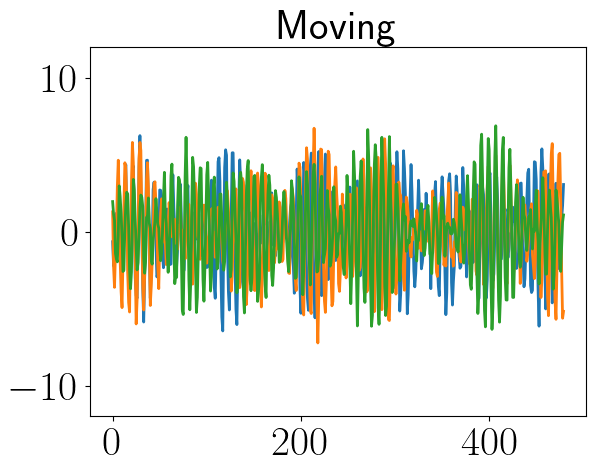

['Moving' 'Feeding']


In [121]:
idx = np.random.choice(len(confusing_obs))
obs = confusing_obs[idx]
window_length = int(window_duration*config.SAMPLING_RATE)
plt.plot(np.arange(window_length), obs['signal'][0,0,:])
plt.plot(np.arange(window_length), obs['signal'][0,1,:])
plt.plot(np.arange(window_length), obs['signal'][0,2,:])
plt.ylim(-12,12)
plt.title(obs['true_behavior'])
plt.show()
print(obs['pset'])

## Result 3: Temporal Context

/home/medhaaga/AWD-Biologging/notebooks/../src/utils/simulations.py:365: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


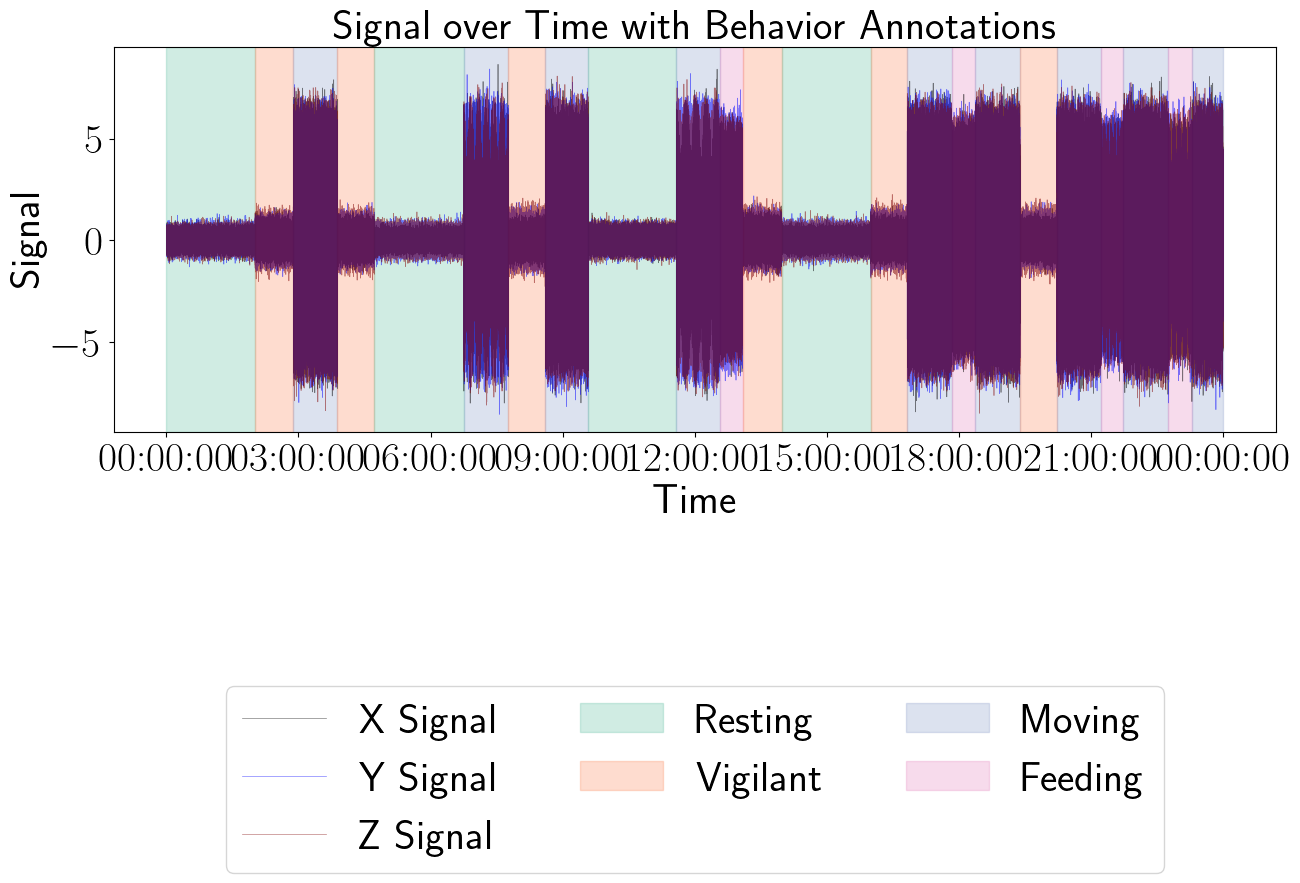

In [122]:
acc_df, annotations_df = simulate_markov_acc_day(config.SIMULATION_CONSTANTS, transition_matrix, avg_durations)
plot_simulated_day(acc_df)

In [130]:
np.random.randint(len(acc_df))

ValueError: low >= high

In [44]:
window_duration = 32.0
model_dir = os.path.join(training_results_dir, f"theta0.6")

In [45]:
acc_df['Timestamp'] = pd.to_datetime(acc_df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
acc_df.sort_values(by='Timestamp', inplace=True)
signal = torch.tensor(np.array([acc_df['Acc X [g]'].values, acc_df['Acc Y [g]'].values, acc_df['Acc Z [g]'].values])).float().unsqueeze(0)

In [46]:
label_encoder = LabelEncoder()
label_encoder.fit(config.BEHAVIORS)
half_day_behaviors = annotations_df
half_day_behaviors = half_day_behaviors.rename(columns={'Timestamp_start': 'behavior_start', 'Timestamp_end': 'behavior_end', 'Behavior': 'behavior'})

/tmp/ipykernel_3428980/2370695748.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


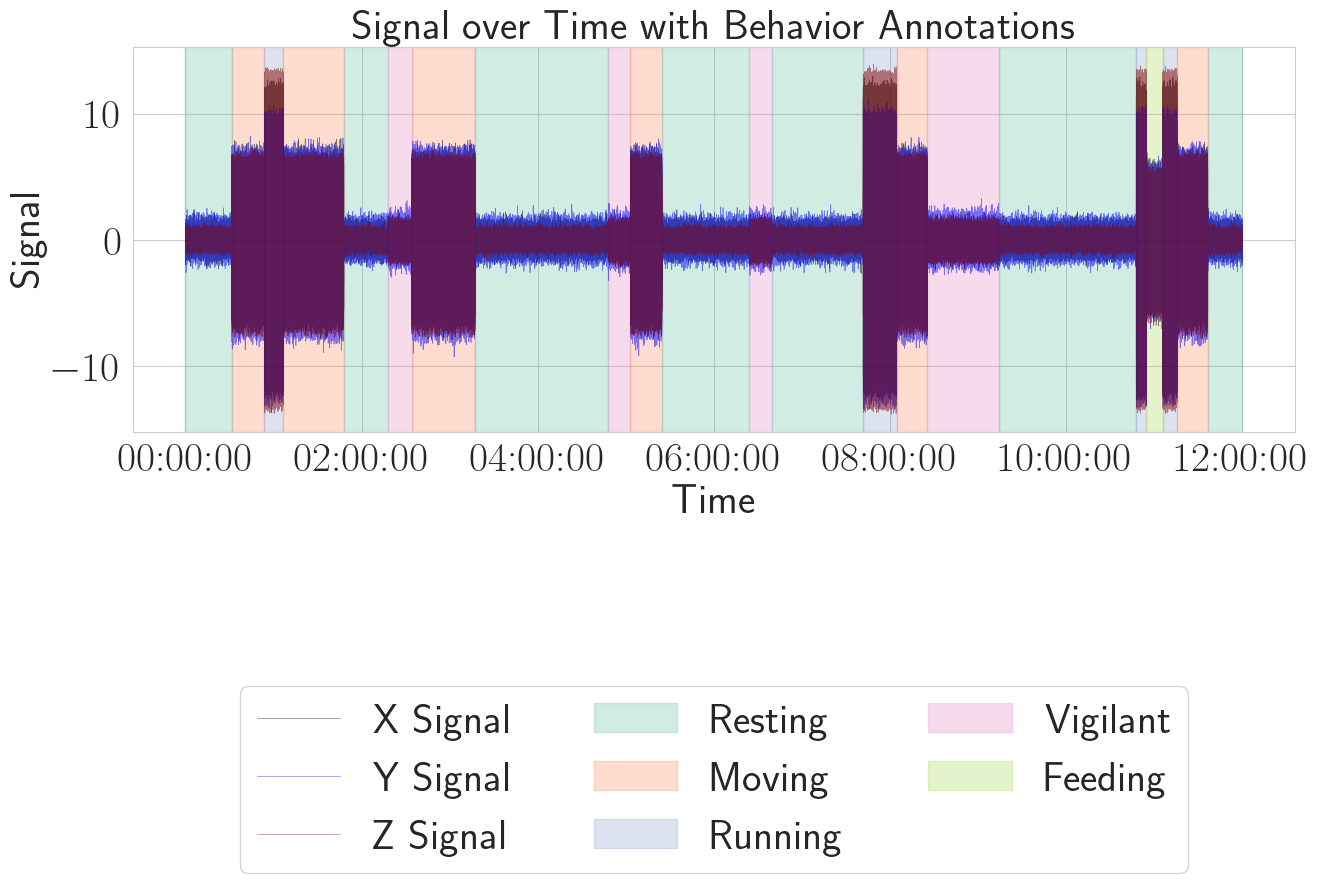

In [47]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure timestamp is datetime
acc_df['Timestamp'] = pd.to_datetime(acc_df['Timestamp'])

# Plot signal
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(acc_df['Timestamp'], acc_df['Acc X [g]'], label='X Signal', color='black', linewidth=.5, alpha=0.5)
ax.plot(acc_df['Timestamp'], acc_df['Acc Y [g]'], label='Y Signal', color='blue', linewidth=.5, alpha=0.5)
ax.plot(acc_df['Timestamp'], acc_df['Acc Z [g]'], label='Z Signal', color='maroon', linewidth=.5, alpha=0.5)


# Get start and end indices for each behavior block
acc_df['behavior_shift'] = acc_df['Behavior'].shift()
acc_df['change'] = acc_df['Behavior'] != acc_df['behavior_shift']
change_indices = acc_df.index[acc_df['change']].tolist() + [acc_df.index[-1] + 1]

# Pick distinct colors for behaviors
import seaborn as sns
colors = dict(zip(acc_df['Behavior'].unique(), sns.color_palette("Set2", acc_df['Behavior'].nunique())))

# Mark regions using axvspan
for start_idx, end_idx in zip(change_indices[:-1], change_indices[1:]):
    row = acc_df.iloc[start_idx]
    behavior = row['Behavior']
    color = colors[behavior]
    ax.axvspan(acc_df.loc[start_idx, 'Timestamp'], acc_df.loc[end_idx - 1, 'Timestamp'],
               alpha=0.3, color=color, label=behavior)

# Format x-axis and legend
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Signal over Time with Behavior Annotations')

# To avoid duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=3, bbox_to_anchor=(0.5, -1.2))

plt.tight_layout()
plt.show()


/home/medhaaga/AWD-Biologging/notebooks/../src/methods/online_predictions.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load(os.path.join(model_dir, 'c

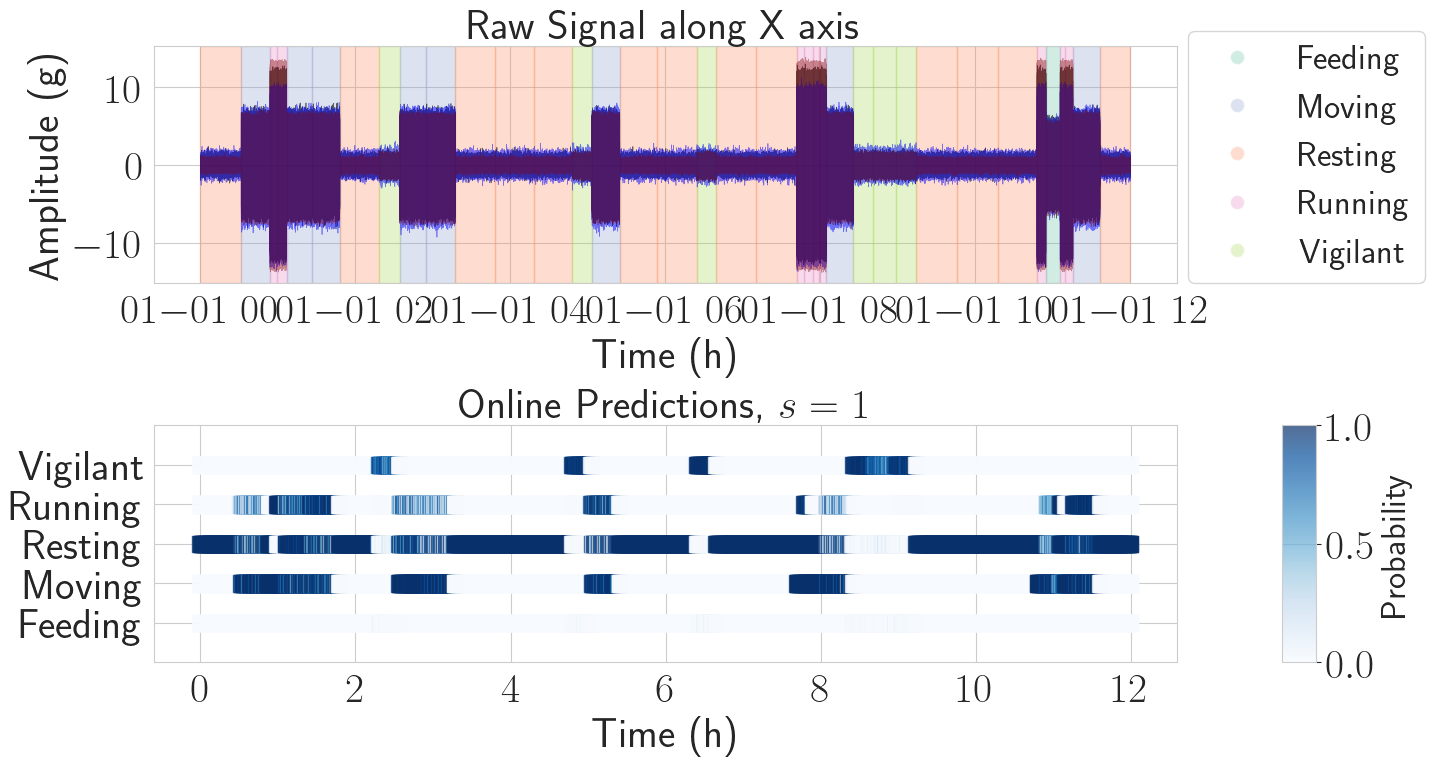

(<Figure size 1500x800 with 3 Axes>,
 (<Axes: title={'center': 'Raw Signal along X axis'}, xlabel='Time (h)', ylabel='Amplitude (g)'>,
  <Axes: title={'center': 'Online Predictions, $s = 1$'}, xlabel='Time (h)'>))

In [48]:
smoothening_config = {'smoothening_window_length': 1,
                          'smoothening_hop_length': 1,
                          'score_hop_length': None
                          }
scores = online_score_evaluation(model_dir=model_dir, X=signal, window_duration=window_duration, window_length=None, hop_length=smoothening_config['score_hop_length'], sampling_frequency=config.SAMPLING_RATE)
online_avg = online_smoothening(scores, smoothening_config['smoothening_window_length'], smoothening_config['smoothening_hop_length'])

plot_signal_and_online_predictions(
    acc_df['Timestamp'],
    signal, 
    online_avg, 
    smoothening_config['smoothening_window_length'], 
    smoothening_config['smoothening_hop_length'], 
    window_duration, 
    label_encoder, 
    sampling_rate=config.SAMPLING_RATE, 
    plot_dir=None,
    half_day_behaviors=half_day_behaviors
)

/home/medhaaga/AWD-Biologging/notebooks/../src/methods/online_predictions.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load(os.path.join(model_dir, 'c

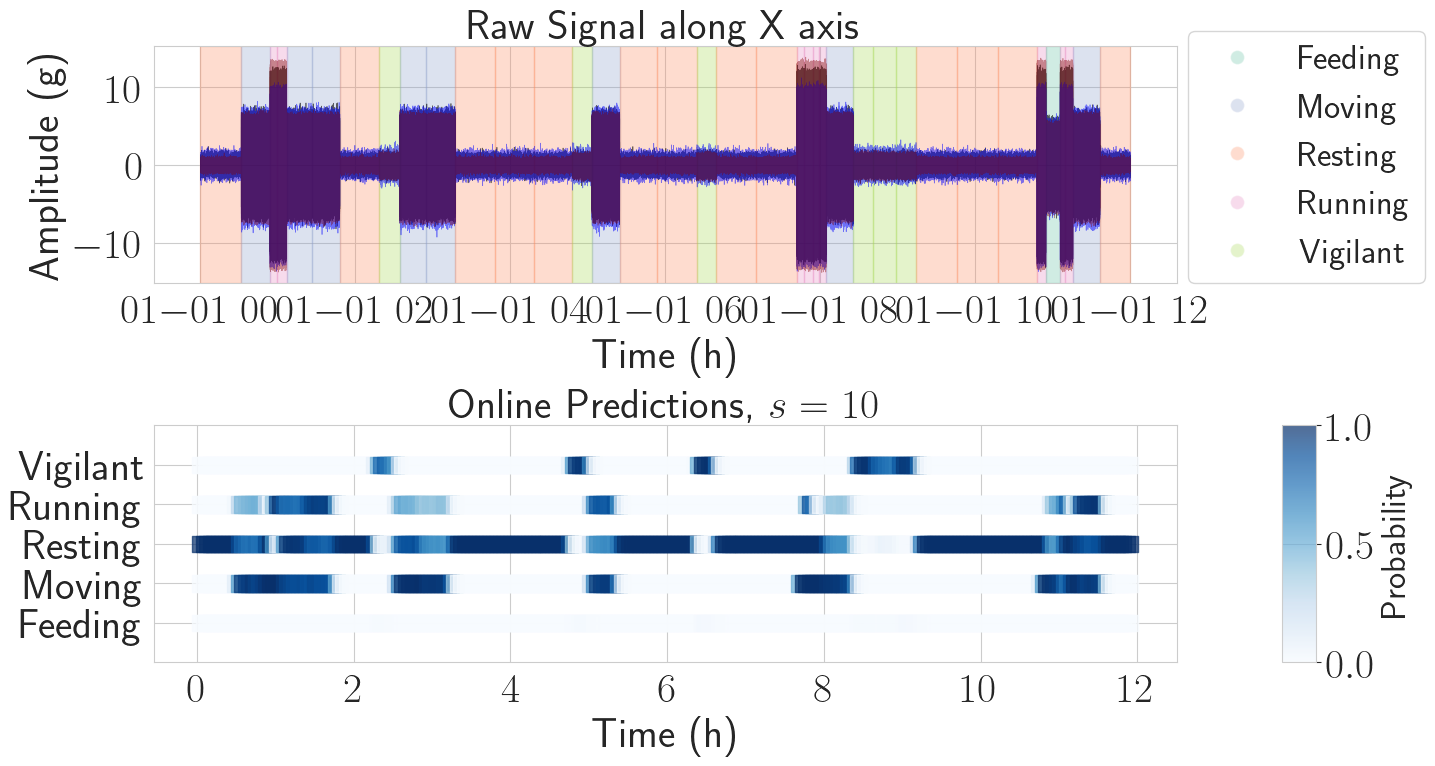

(<Figure size 1500x800 with 3 Axes>,
 (<Axes: title={'center': 'Raw Signal along X axis'}, xlabel='Time (h)', ylabel='Amplitude (g)'>,
  <Axes: title={'center': 'Online Predictions, $s = 10$'}, xlabel='Time (h)'>))

In [51]:
smoothening_config = {'smoothening_window_length': 10,
                          'smoothening_hop_length': 5,
                          'score_hop_length': None
                          }
                          
scores = online_score_evaluation(model_dir=model_dir, X=signal, window_duration=window_duration, window_length=None, hop_length=smoothening_config['score_hop_length'], sampling_frequency=config.SAMPLING_RATE)
online_avg = online_smoothening(scores, smoothening_config['smoothening_window_length'], smoothening_config['smoothening_hop_length'])

plot_signal_and_online_predictions(
    acc_df['Timestamp'],
    signal, 
    online_avg, 
    smoothening_config['smoothening_window_length'], 
    smoothening_config['smoothening_hop_length'], 
    window_duration, 
    label_encoder, 
    sampling_rate=config.SAMPLING_RATE, 
    plot_dir=None,
    half_day_behaviors=half_day_behaviors
)

## Result 4: Distribution Shift

In [253]:
# experiment paths

results_dir = os.path.join(config.TEST_ROOT_DIR, "distribution_shift")
os.makedirs(results_dir, exist_ok=True)

# define paths for various objects for this result subsection
training_results_dir = os.path.join(results_dir, "training_results")
os.makedirs(training_results_dir, exist_ok=True)

In [285]:
young_data_constants = [
    
    # Feeding — bring down the amplitude and overlap with Moving
    ("Feeding", "X", (1.4, 1.5, 1.7), (1.1, 1.2, 1.3), (0.2, 0.7, 1.2), 0.5),
    ("Feeding", "Y", (1.3, 1.5, 1.6), (1.1, 1.2, 1.4), (0.3, 0.8, 1.3), 0.6),
    ("Feeding", "Z", (1.5, 1.5, 1.8), (1.1, 1.2, 1.5), (0.4, 0.9, 1.4), 0.5),

    # Moving — slightly reduce amplitude, overlap more with Feeding
    ("Moving", "X", (1.9, 2.0, 2.2), (1.7, 1.9, 2.3), (0.6, 1.2, 1.8), 0.7),
    ("Moving", "Y", (1.9, 2.0, 2.1), (2.0, 2.0, 2.2), (0.5, 1.0, 1.5), 0.6),
    ("Moving", "Z", (2.0, 2.1, 2.2), (2.0, 2.1, 2.2), (0.7, 1.2, 1.8), 0.6),

    # Resting — make it slightly jittery to overlap with Vigilant
    ("Resting", "X", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.15),
    ("Resting", "Y", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.2),
    ("Resting", "Z", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.2),

    # Vigilant — lower the amplitude and raise noise to blur with Resting
    ("Vigilant", "X", (0.6, 0.5, 0.8), (0.5, 0.5, 0.6), (0.0, 0.3, 0.6), 0.3),
    ("Vigilant", "Y", (0.5, 0.5, 0.8), (0.6, 0.5, 0.7), (0.0, 0.4, 0.8), 0.35),
    ("Vigilant", "Z", (0.7, 0.6, 0.7), (0.7, 0.5, 0.6), (0.0, 0.5, 1.0), 0.4),
]


adult_data_constants = [
    
    # Feeding — bring down the amplitude and overlap with Moving
    ("Feeding", "X", (1.6, 1.8, 1.9), (1.5, 1.5, 1.5), (0.2, 0.7, 1.2), 0.5),
    ("Feeding", "Y", (1.7, 1.7, 1.9), (1.4, 1.6, 1.7), (0.3, 0.8, 1.3), 0.6),
    ("Feeding", "Z", (1.7, 1.7, 2.1), (1.4, 1.5, 1.8), (0.4, 0.9, 1.4), 0.5),

    # Moving — slightly reduce amplitude, overlap more with Feeding
    ("Moving", "X", (1.9, 1.9, 2.1), (1.7, 1.7, 2.0), (0.6, 1.2, 1.8), 0.7),
    ("Moving", "Y", (1.7, 1.9, 2.0), (1.8, 1.8, 2.0), (0.5, 1.0, 1.5), 0.6),
    ("Moving", "Z", (1.8, 2.0, 2.1), (1.8, 1.8, 2.0), (0.7, 1.2, 1.8), 0.6),

    # Resting — make it slightly jittery to overlap with Vigilant
    ("Resting", "X", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.15),
    ("Resting", "Y", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.2),
    ("Resting", "Z", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.2),

    # Vigilant — lower the amplitude and raise noise to blur with Resting
    ("Vigilant", "X", (0.4, 0.3, 0.6), (0.3, 0.4, 0.4), (0.0, 0.3, 0.6), 0.2),
    ("Vigilant", "Y", (0.3, 0.3, 0.6), (0.3, 0.4, 0.3), (0.0, 0.4, 0.8), 0.2),
    ("Vigilant", "Z", (0.4, 0.4, 0.6), (0.2, 0.3, 0.3), (0.0, 0.5, 1.0), 0.2),
]

young_data_constants = pd.DataFrame(young_data_constants, columns=[
    "Behavior", "Axis", "f", "A", "phi", "sigma"
])

adult_data_constants = pd.DataFrame(adult_data_constants, columns=[
    "Behavior", "Axis", "f", "A", "phi", "sigma"
])

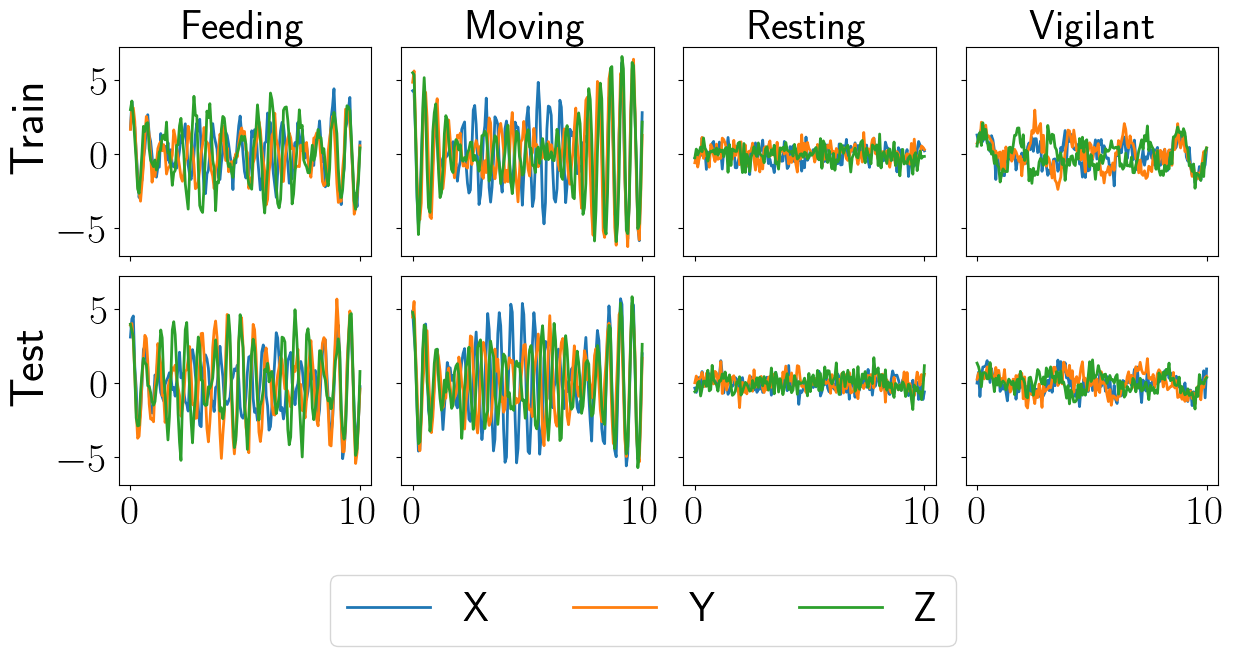

In [286]:
t = np.linspace(0, 10, 160)
fig, axs = plt.subplots(2, len(config.SIM_BEHAVIORS), figsize=(3*len(config.SIM_BEHAVIORS), 6), sharey=True, sharex=True)

for i, observed_behavior in enumerate(config.SIM_BEHAVIORS):

    # Young individuals
    f_X, A_X, phi_X = young_data_constants.loc[(young_data_constants["Behavior"] == observed_behavior) & (young_data_constants["Axis"] == "X"), ['f', 'A', 'phi']].values[0]
    f_Y, A_Y, phi_Y = young_data_constants.loc[(young_data_constants["Behavior"] == observed_behavior) & (young_data_constants["Axis"] == "Y"), ['f', 'A', 'phi']].values[0]
    f_Z, A_Z, phi_Z = young_data_constants.loc[(young_data_constants["Behavior"] == observed_behavior) & (young_data_constants["Axis"] == "Z"), ['f', 'A', 'phi']].values[0]

    signal_x = simulate_fourier_signal(list(f_X), list(A_X), list(phi_X), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
    signal_y = simulate_fourier_signal(list(f_Y), list(A_Y), list(phi_Y), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
    signal_z = simulate_fourier_signal(list(f_Z), list(A_Z), list(phi_Z), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))

    axs[0, i].plot(t, signal_x)
    axs[0, i].plot(t, signal_y)
    axs[0, i].plot(t, signal_z)
    axs[0, i].set_title(observed_behavior)

    # Adult individuals
    f_X, A_X, phi_X = adult_data_constants.loc[(adult_data_constants["Behavior"] == observed_behavior) & (adult_data_constants["Axis"] == "X"), ['f', 'A', 'phi']].values[0]
    f_Y, A_Y, phi_Y = adult_data_constants.loc[(adult_data_constants["Behavior"] == observed_behavior) & (adult_data_constants["Axis"] == "Y"), ['f', 'A', 'phi']].values[0]
    f_Z, A_Z, phi_Z = adult_data_constants.loc[(adult_data_constants["Behavior"] == observed_behavior) & (adult_data_constants["Axis"] == "Z"), ['f', 'A', 'phi']].values[0]

    signal_x = simulate_fourier_signal(list(f_X), list(A_X), list(phi_X), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
    signal_y = simulate_fourier_signal(list(f_Y), list(A_Y), list(phi_Y), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
    signal_z = simulate_fourier_signal(list(f_Z), list(A_Z), list(phi_Z), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))

    if i == 0:
        axs[1, i].plot(t, signal_x, label='X')
        axs[1, i].plot(t, signal_y, label='Y')
        axs[1, i].plot(t, signal_z, label='Z')
    else:
        axs[1, i].plot(t, signal_x)
        axs[1, i].plot(t, signal_y)
        axs[1, i].plot(t, signal_z)

fig.text(-0.01, 0.7, 'Train', ha='center', va='center', fontsize=34, fontweight='bold', rotation=90)
fig.text(-0.01, 0.3, 'Test', ha='center', va='center', fontsize=34, fontweight='bold', rotation=90)

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2))
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space at the top for titles
plt.show()


In [287]:
# Define individuals and years of dataset available for them
young_individuals = {"individual1": [2022],
               "individual2": [2022]}

adult_individuals = {"individual1": [2025],
               "individual2": [2025]}
               
max_durations = {
        "Feeding": {"min": 2, "sec": 60},
        "Moving": {"min": 4, "sec": 60},
        "Resting": {"min": 6, "sec": 60},
        "Vigilant": {"min": 6, "sec": 60}
    }
max_durations = pd.DataFrame.from_dict(max_durations, orient="index")
max_durations.index.name = "Behavior"
max_durations.columns.name = "DurationUnit"

young_behavior_prob = dict(zip(config.SIM_BEHAVIORS, [0.1, 0.4, 0.45, 0.05]))
adult_behavior_prob = dict(zip(config.SIM_BEHAVIORS, [0.05, 0.4, 0.5, 0.05]))


In [288]:
window_length = int(30.0 * config.SAMPLING_RATE)
from src.utils.simulations import generate_dataset
from sklearn.model_selection import train_test_split

n_train, n_test = 2000, 500
X_train, y_train = generate_dataset(young_data_constants, young_behavior_prob, window_length, n_train, wrong_behavior=False, wrong_behavior_prob=0.1)
X_test, y_test = generate_dataset(adult_data_constants, adult_behavior_prob, window_length, n_test)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=42
)

label_encoder = LabelEncoder()
label_encoder.fit(config.SIM_BEHAVIORS)
y_train, y_val, y_test = label_encoder.transform(y_train), label_encoder.transform(y_val), label_encoder.transform(y_test)

In [289]:

@dataclass
class Arguments:
    experiment_name: str
    batch_size: int
    window_duration_percentile: float
    train_test_split: float
    train_val_split: float
    padding: str
    theta: float
    filter_type: str
    cutoff_frequency: float
    cutoff_order: int
    normalization: int
    match: int
    min_duration: float
    n_CNNlayers: int
    n_channels: int
    kernel_size: int
    learning_rate: float
    weight_decay: float
    num_epochs: int
    alpha: float
    verbose: int

args = Arguments(
    experiment_name='no_split', batch_size=64, window_duration_percentile=20, 
    train_test_split=0.2, train_val_split=0.2, padding='repeat', theta=0.0, 
    filter_type='high', cutoff_frequency=0, cutoff_order=5, normalization=0,
    match=0, min_duration=1.0, n_CNNlayers=5, n_channels=16, kernel_size=5,
    learning_rate=0.0001, weight_decay=0.0001, num_epochs=100, alpha=0.05, verbose=0
)


In [290]:
args.experiment_name = 'test_interyear'
args.theta= 0.8

train_filter_profile, test_filter_profile = utils_data.get_exp_filter_profiles(args.experiment_name)

print('INTERYEAR')
print(f"{'train filter':<15} {train_filter_profile}")
print(f"{'test filter':<15} {test_filter_profile}")

INTERYEAR
train filter    {'individual ID': None, 'year': [2022], 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}
test filter     {'individual ID': None, 'year': [2025], 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}


In [291]:
n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(np.concatenate((y_train, y_val, y_test))))

print("Train Class distribution")
print("==========================")
print(pd.DataFrame(np.unique(y_train, return_counts=True)[1])/y_train.shape[0])
print("")

print("Test Class distribution")
print("==========================")
print(pd.DataFrame(np.unique(y_test, return_counts=True)[1])/y_test.shape[0])
print("")

print("Shape of dataframes")
print("==========================")
print(f"{'Set':<8} {'X':<15} {'Y':<10} ")
print(f"{'Train:':<8} {str(X_train.shape):<15} {str(y_train.shape):<10} ")
print(f"{'Val:':<8} {str(X_val.shape):<15} {str(y_val.shape):<10} ")
print(f"{'Test:':<8} {str(X_test.shape):<15} {str(y_test.shape):<10} ")

Train Class distribution
          0
0  0.092500
1  0.375625
2  0.481250
3  0.050625

Test Class distribution
       0
0  0.052
1  0.414
2  0.498
3  0.036

Shape of dataframes
Set      X               Y          
Train:   (1600, 3, 480)  (1600,)    
Val:     (400, 3, 480)   (400,)     
Test:    (500, 3, 480)   (500,)     


In [292]:
import torch.nn as nn
import torch.optim as optim

train_dataloader, val_dataloader, test_dataloader = utils_data.setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# Define the sequential model
model = create_dynamic_conv_model(n_features, n_timesteps, n_outputs, 
                                        num_conv_layers=args.n_CNNlayers, 
                                        base_channels=args.n_channels, 
                                        kernel_size=args.kernel_size).to(device)

print("")
print("==================================")
print(f"Number of trainable model paramters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

#########################################
#### Training
#########################################

train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, args, device)
model = train_obj['model']
training_stats = train_obj['training_stats']

model_dir = os.path.join(training_results_dir, f"theta{args.theta}")
os.makedirs(model_dir, exist_ok=True)
torch.save(model, os.path.join(model_dir, 'model.pt'))
json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
with open(json_training_stats_file, 'w') as f:
    json.dump(training_stats, f)


# save true and predicted test classes along with test metadata
np.save(os.path.join(model_dir, 'test_true_classes.npy'), train_obj['test_true_classes'])
np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])

# save true and predicted validation classes along with val metadata
np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])




Number of trainable model paramters: 233700


Epoch 100/100 | Train Loss: 0.0000 | Val Loss: 0.0000: 100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


Total training time: 0:00:33


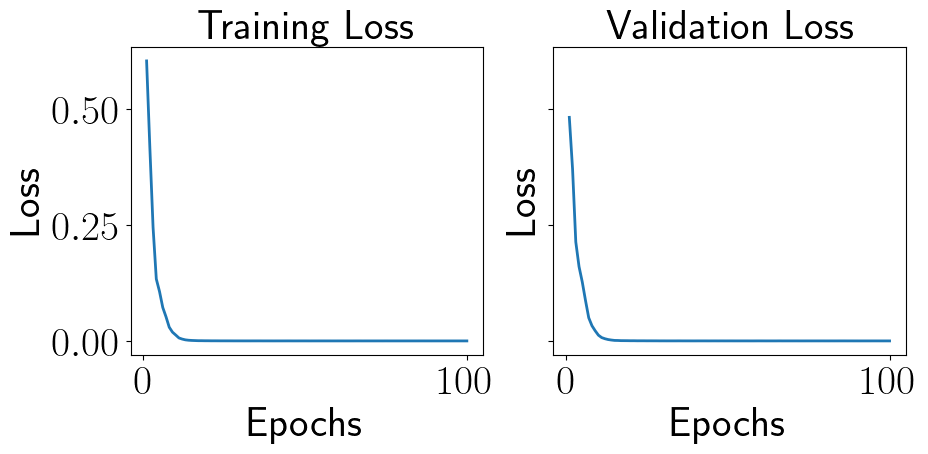

In [293]:
#plot training stats
training_stats = pd.DataFrame(training_stats)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].plot(training_stats['epoch'], training_stats['Training Loss'])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")

axs[1].plot(training_stats['epoch'], training_stats['Validation Loss'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Validation Loss")
plt.show()

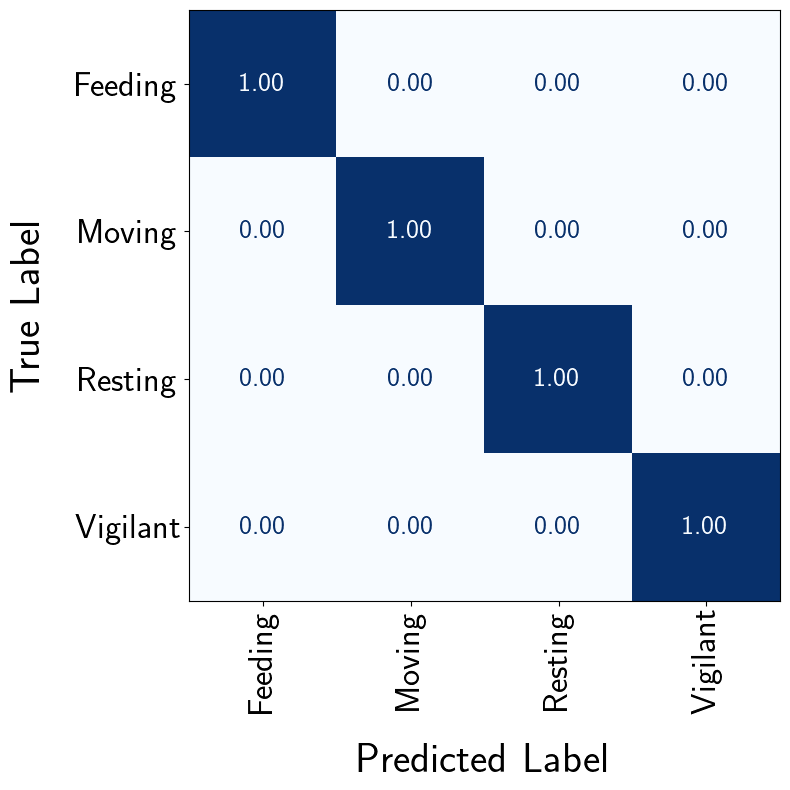

In [294]:
multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=True, return_accuracy=False, plot_path=None)

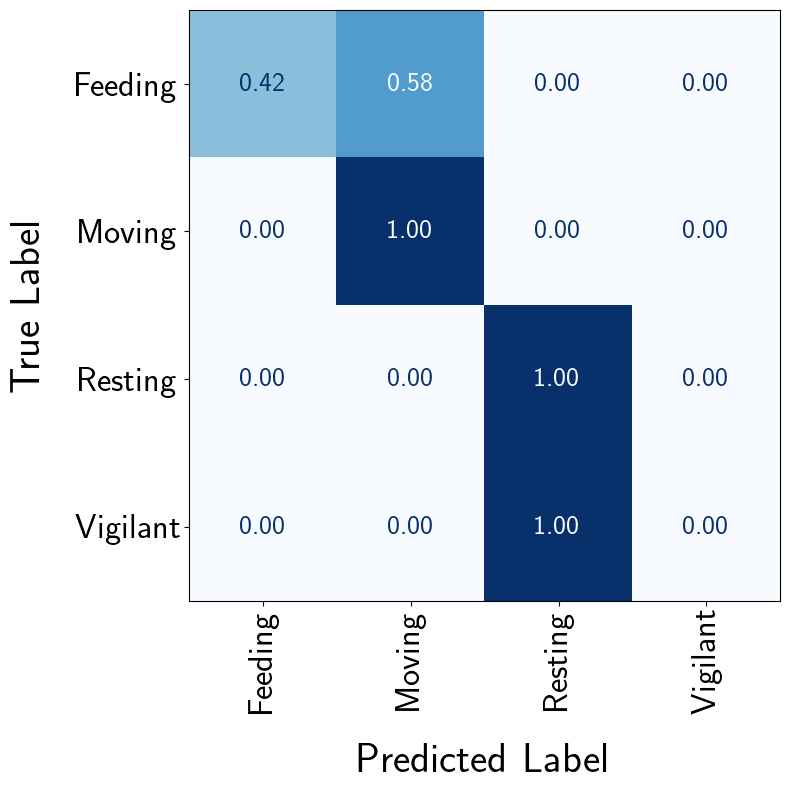

In [296]:
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=None)

In [297]:
print("VALIDATION SET")
print("")

print('VAL PRECISION SCORE')
print('---------------------')
precision = np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True, average='macro'), 3)
print(f'Average precision: {precision}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'precision': np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True, average=None), 3)}))

print('VAL RECALL SCORE')
print('---------------------')
recall = np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True, average='macro'), 3)
print(f'Average recall: {recall}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'recall': np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True, average=None), 3)}))

print('VAL F1 SCORE')
print('---------------------')
f1 = np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True, average='macro'), 3)
print(f'Average F1 score: {f1}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'f1 score': np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True, average=None), 3)}))

print('VAL ACCURACY')
print('---------------------')
accuracy = np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_accuracy=True), 3)
print(f'Accuracy: {accuracy}')

VALIDATION SET

VAL PRECISION SCORE
---------------------
Average precision: 1.0
   behavior  precision
0   Feeding        1.0
1    Moving        1.0
2   Resting        1.0
3  Vigilant        1.0
VAL RECALL SCORE
---------------------
Average recall: 1.0
   behavior  recall
0   Feeding     1.0
1    Moving     1.0
2   Resting     1.0
3  Vigilant     1.0
VAL F1 SCORE
---------------------
Average F1 score: 1.0
   behavior  f1 score
0   Feeding       1.0
1    Moving       1.0
2   Resting       1.0
3  Vigilant       1.0
VAL ACCURACY
---------------------
Accuracy: 1.0


In [298]:
print("TEST SET")
print("")


print('TEST PRECISION SCORE')
print('---------------------')
precision = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average='macro'), 3)
print(f'Average precision: {precision}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'precision': np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average=None), 3)}))

print('TEST RECALL SCORE')
print('---------------------')
recall = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average='macro'), 3)
print(f'Average recall: {recall}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'recall': np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average=None), 3)}))

print('TEST F1 SCORE')
print('---------------------')
f1 = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average='macro'), 3)
print(f'Average F1 score: {f1}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'f1 score': np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average=None), 3)}))

print('TEST ACCURACY')
print('---------------------')
accuracy = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True), 3)
print(f'Accuracy: {accuracy}')

TEST SET

TEST PRECISION SCORE
---------------------
Average precision: 0.716
   behavior  precision
0   Feeding      1.000
1    Moving      0.932
2   Resting      0.933
3  Vigilant      0.000
TEST RECALL SCORE
---------------------
Average recall: 0.606
   behavior  recall
0   Feeding   0.423
1    Moving   1.000
2   Resting   1.000
3  Vigilant   0.000
TEST F1 SCORE
---------------------
Average F1 score: 0.631
   behavior  f1 score
0   Feeding     0.595
1    Moving     0.965
2   Resting     0.965
3  Vigilant     0.000
TEST ACCURACY
---------------------
Accuracy: 0.934


/home/medhaaga/miniconda3/envs/wildlife/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/medhaaga/miniconda3/envs/wildlife/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [299]:
from scipy.stats import skew, kurtosis

features = ['Mean', 'Std. Dev.', 'Skewness', 'Kurtosis', 'Minimum', 'Maximum', 'Energy', '\% of Increase']
def extract_features(ts):  # ts is (N, 3, T)
    features = []
    for axis in range(ts.shape[1]):  # axis shape is (T,)
        axis_data = ts[:,axis,:] # shape (N, T)
        features.append(np.stack([
            np.mean(axis_data, axis=1), # shape (N, )
            np.std(axis_data, axis=1), # shape (N, )
            skew(axis_data, axis=1), # shape (N, )
            kurtosis(axis_data, axis=1), # shape (N, )
            np.min(axis_data, axis=1), # shape (N, )
            np.max(axis_data, axis=1), # shape (N, )
            np.sum(axis_data ** 2, axis=1),  # energy
            np.mean(np.diff(axis_data) > 0, axis=1),  # percent of increases
        ], axis=1)) # shape (N, k)
    return np.concatenate(features, axis=1)  # shape (3 × k)



In [300]:
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)
print(X_train_features.shape, X_test_features.shape)

(1600, 24) (500, 24)


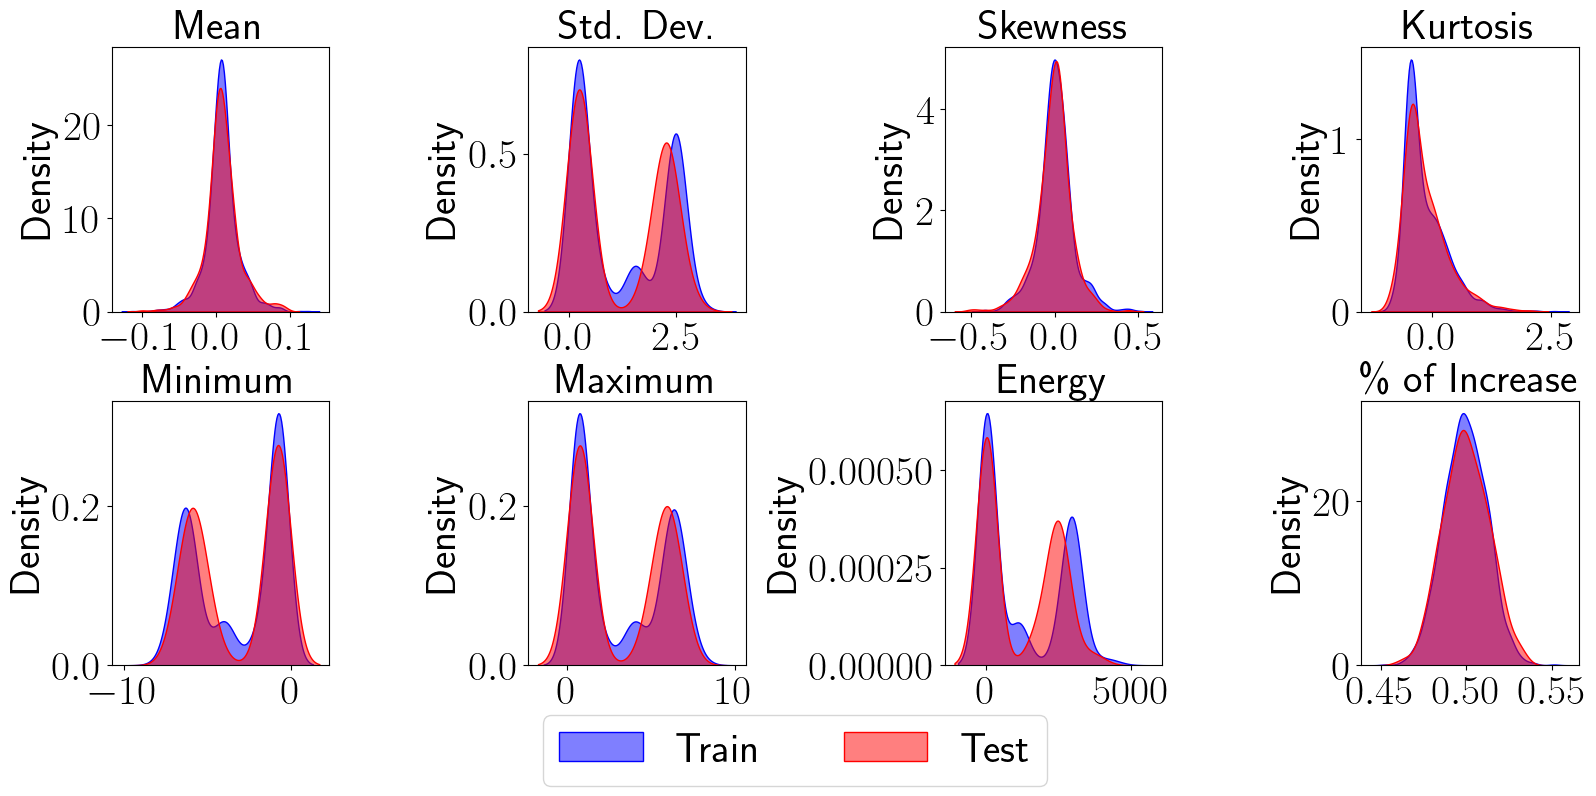

In [301]:
# Create subplots (1 row, 6 columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Loop over each feature (marginal) and plot the KDE for both datasets
for i in range(8):
    ax = axes[i//4, i%4]
    if i == 0:
        sns.kdeplot(X_train_features[:, i], ax=ax, label="Train", color="blue", fill=True, alpha=0.5)
        sns.kdeplot(X_test_features[:, i], ax=ax, label="Test", color="red", fill=True, alpha=0.5)
    else:
        sns.kdeplot(X_train_features[:, i], ax=ax,  color="blue", fill=True, alpha=0.5)
        sns.kdeplot(X_test_features[:, i], ax=ax, color="red", fill=True, alpha=0.5) 
    ax.set_title(features[i])

plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show the plot
fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.show()

In [302]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Standardize the datasets
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

In [303]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

def mmd_squared_rbf(X, Y, gamma=1.0):
    """
    Computes squared MMD using RBF kernel between two sets of samples X and Y.
    
    Parameters:
        X (np.ndarray): First dataset, shape (n1, d)
        Y (np.ndarray): Second dataset, shape (n2, d)
        gamma (float): Kernel parameter for RBF.
        
    Returns:
        float: Squared Maximum Mean Discrepancy (MMD) using RBF kernel.
    """
    # Compute the RBF kernel between all pairs of samples in X, Y
    KXX = rbf_kernel(X, X, gamma=gamma)
    KYY = rbf_kernel(Y, Y, gamma=gamma)
    KXY = rbf_kernel(X, Y, gamma=gamma)

    # Compute MMD squared using the kernel
    mmd2 = np.mean(KXX) + np.mean(KYY) - 2 * np.mean(KXY)
    return mmd2

# Example usage
mmd_value = mmd_squared_rbf(X_train_features, X_test_features, gamma=1.0)
print("Squared MMD using RBF kernel:", mmd_value)


Squared MMD using RBF kernel: 0.002735260119698163
